In [1]:
import os
import re
import sys
import uproot
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

from functools import partial

In [2]:
### Import functions from peak_functions

repository_path = os.path.abspath('../..')
sys.path.append(repository_path)

import blr_functions  as blr
import peak_functions as pf
import fit_functions  as fitf

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
plt.rcParams["figure.figsize"] = 8, 5
plt.rcParams["font.size"]      = 11

In [5]:
filename = '/Users/romoluque_c/LEGEND/BACON/datatest/run-11_20_2023-file_1.root'
infile   = uproot.open(filename)
RawTree  = infile['RawTree']

In [7]:
evts_path = '/Users/romoluque_c/LEGEND/BACON/data_npz/'

normal_chs  = range(9)
trigger_chs = [9, 10, 11]

filt_evts_all             = {}
idx_peaks_ch_all          = {}
height_peaks_ch_all       = {}
idx_peaks_ch_trigg_all    = {}
height_peaks_ch_trigg_all = {}

def extract_date_and_number(filename):
    match = re.search(r"(\d{2}_\d{2}_\d{4})-file_(\d+)", filename)
    return match.group(1), int(match.group(2))

def adapt_evt_id(evt_id, fnum):
    return 1000000*fnum + np.array(evt_id)

files        = os.listdir(evts_path)
filt_files   = [file for file in files if file.startswith("BACoN_hits_and_times_run-11_20")]
sorted_files = sorted(filt_files, key=extract_date_and_number)

for filename in sorted_files[1:2]:
    my_file    = evts_path+filename
    d          = np.load(my_file, allow_pickle=True)
    date, fnum = extract_date_and_number(filename)
    print(date, fnum)
        
    if date not in filt_evts_all:
        filt_evts_all            [date] = d['filt_evts_dict']            .item()
        idx_peaks_ch_all         [date] = d['idx_peaks_ch_dict']         .item()
        height_peaks_ch_all      [date] = d['height_peaks_ch_dict']      .item()
        idx_peaks_ch_trigg_all   [date] = d['idx_peaks_ch_trigg_dict']   .item()
        height_peaks_ch_trigg_all[date] = d['height_peaks_ch_trigg_dict'].item()
        continue
    
    for ch in normal_chs:
        try:
            filt_evts_all            [date][ch] = np.concatenate((filt_evts_all      [date][ch], adapt_evt_id(d['filt_evts_dict'].item()[ch], fnum)))
            idx_peaks_ch_all         [date][ch] = np.concatenate((idx_peaks_ch_all   [date][ch], d['idx_peaks_ch_dict']          .item()[ch]))
            height_peaks_ch_all      [date][ch] = np.concatenate((height_peaks_ch_all[date][ch], d['height_peaks_ch_dict']       .item()[ch]))
        except ValueError:
            print(date, fnum, filename, ch)
            continue

        for ch in trigger_chs:
            idx_peaks_ch_trigg_all   [date][ch] = np.concatenate((idx_peaks_ch_trigg_all   [date][ch], d['idx_peaks_ch_trigg_dict']   .item()[ch]))
            height_peaks_ch_trigg_all[date][ch] = np.concatenate((height_peaks_ch_trigg_all[date][ch], d['height_peaks_ch_trigg_dict'].item()[ch]))

11_20_2023 1


In [9]:
filt_evts_all;

In [16]:
normal_chs = range(9)
trigg_chs  = [9, 10, 11]

In [49]:
signal_evts = np.unique(np.concatenate(list(filt_evts_all['11_20_2023'].values())))

wfs_evts_with_peaks = {ch: pf.wfs_from_rawtree(RawTree, ch)[signal_evts.astype(int)]
                       for ch in normal_chs}

max_smpl_bsl  = 650
subt_wfs_dict = {ch: pf.subtract_baseline(wfs_evts_with_peaks[ch], mode=True, wf_range_bsl=(0, max_smpl_bsl))
                 for ch in range(9)}

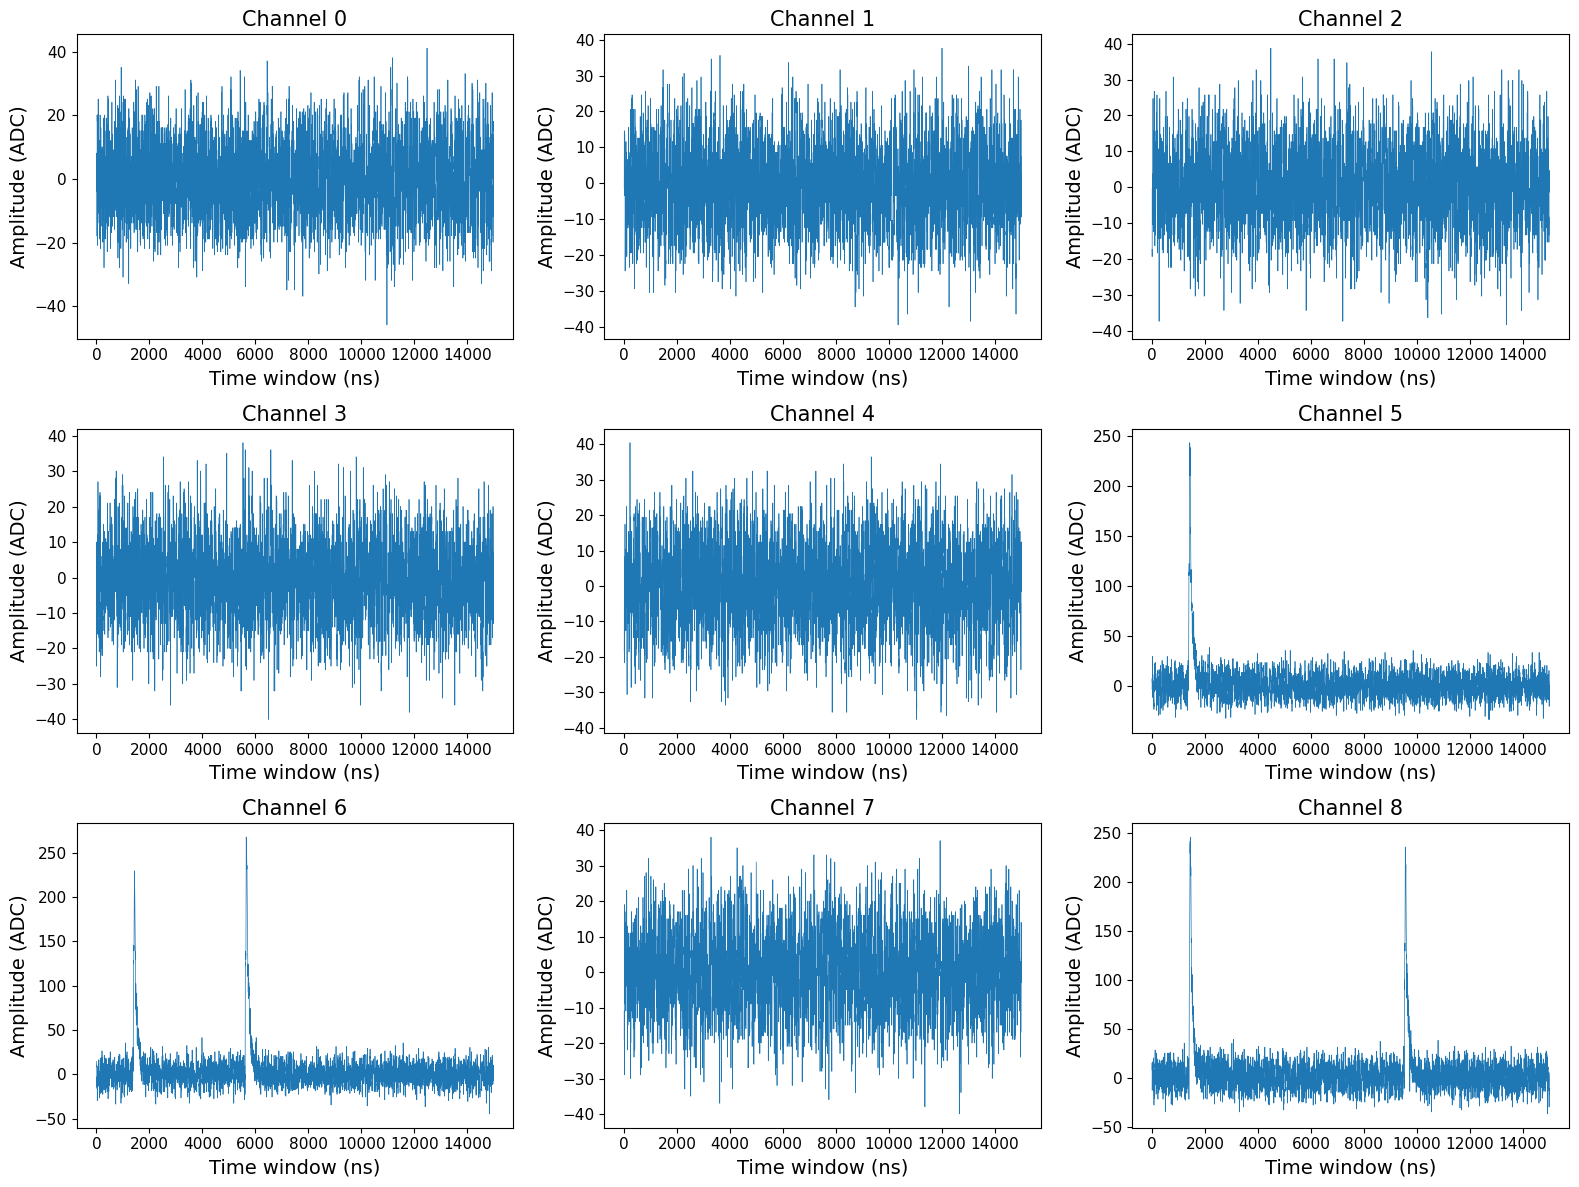

In [54]:
sel_evt  = 0
fig, axs = plt.subplots(3, 3, figsize=(16, 12))
for k in range(9):
    i = int(k/3)
    j = k%3
    sel_wf = subt_wfs_dict[k][sel_evt]
    axs[i][j].plot(2*np.arange(len(sel_wf)), sel_wf, linewidth=0.5)
    axs[i][j].set_xlabel('Time window (ns)', fontsize=14)
    axs[i][j].set_ylabel('Amplitude (ADC)', fontsize=14)
    axs[i][j].set_title(f"Channel {k}", fontsize=15)
plt.tight_layout()
plt.show()

In [55]:
summed_swfs_norm_join_evts_dict = {ch: np.sum(subt_wfs_dict[ch], axis=0)/len(subt_wfs_dict[ch])
                                   for ch in normal_chs}

In [56]:
gains = [228.60604565191687, 206.34311805972095, 221.9751025687914, 215.06932276978736, 224.8076710540091,
         230.50097040107894, 226.52495525686777, 231.59231748969287, 225.42814952613816]

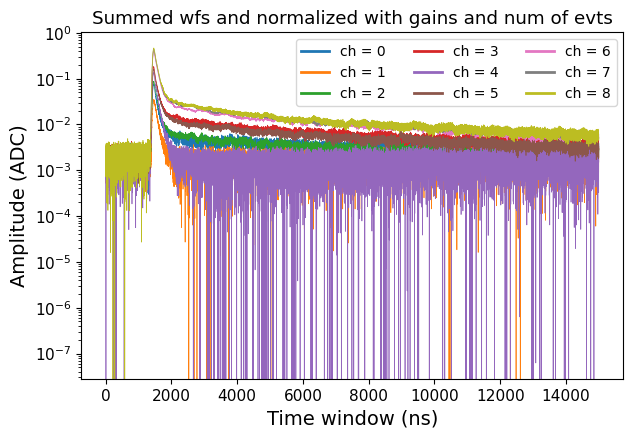

In [57]:
plt.figure(figsize=(7, 4.5))
for ch, gain in enumerate(gains):
    sum_wfs_norm_cal = summed_swfs_norm_join_evts_dict[ch]/gain
    plt.plot(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal, linewidth=0.5, label=f'ch = {ch}')
    plt.title('Summed wfs and normalized with gains and num of evts')
    plt.xlabel('Time window (ns)', fontsize=14)
    plt.ylabel('Amplitude (ADC)', fontsize=14)
    plt.yscale('log')
leg = plt.legend(ncol=3, fontsize=10)
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

## First attemp to fit one spectrum

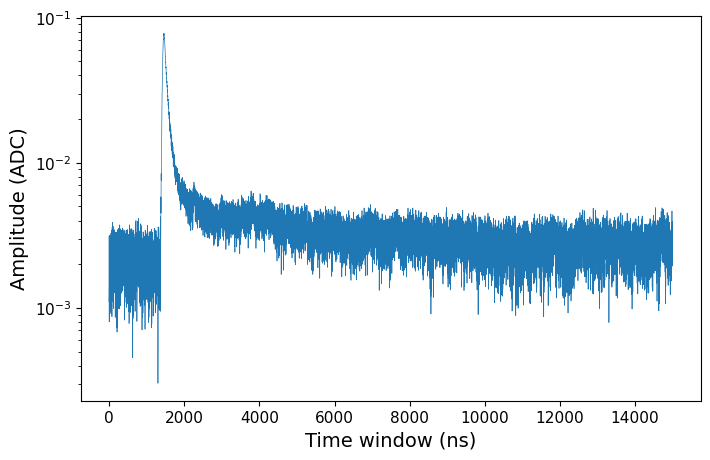

In [58]:
sel_ch = 0
sum_wfs_norm_cal = summed_swfs_norm_join_evts_dict[sel_ch]/gain
plt.plot(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal, linewidth=0.5, label=f'ch = {ch}')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.yscale('log')
plt.show()

In [104]:
np.sum(sum_wfs_norm_cal)

27.760782

In [63]:
!pip install iminuit

  Using cached iminuit-2.24.0-cp310-cp310-macosx_10_9_universal2.whl (650 kB)


In [80]:
sum_wfs_norm_cal

array([0.00110002, 0.00125302, 0.00313435, ..., 0.001966  , 0.00391957,
       0.00194511], dtype=float32)

In [82]:
a, b = np.histogram(sum_wfs_norm_cal)
len(a), len(b)

(10, 11)

In [113]:
np.max(sum_wfs_norm_cal)

0.078173056

In [123]:
sum_wfs_norm_cal

array([0.00110002, 0.00125302, 0.00313435, ..., 0.001966  , 0.00391957,
       0.00194511], dtype=float32)

In [139]:
from scipy.stats import uniform
from numba_stats import truncnorm, truncexpon, norm, expon
from iminuit import cost
from iminuit import Minuit

xr = (0,5000)
def integral_all_free(x, b, tau1, s1, s2, tau2):
    """ This function defines a model for fitting. It is a combination of a truncated exponential
    distribution (truncexpon) and a uniform distribution (uniform).
    
    Parameter 1 (b): fraction or probability. 
        It could represent the fraction of events modeled by the exponential distribution in this case.

    Parameter 2 (tau1): Represents the scale or decay parameter of the first truncexpon distribution 
    in the model. It could be related to the characteristic time scale of the exponential decay.

    Parameter 3 (s1): Multiplier for the entire first part of the model. It scales the amplitude of the
    exponential component.

    Parameter 4 (s2): Scale or width of the uniform distribution in the model (width of a constant background.)

    Parameter 5 (tau2): scale or decay parameter of the second truncexpon distribution in the model.
        Similar to Parameter 2, but for the second exponential distribution.
    
    
    """
    return s * (  (  b  * truncexpon.cdf(x, *xr, 0.0, tau1) 
                + (1-b) * truncexpon.cdf(x, *xr, 0.0, tau2)))# + s2 * uniform.cdf(x, *xr)


#n, xe = 2*np.arange(len(sum_wfs_norm_cal))[1:], sum_wfs_norm_cal
n, xe = np.histogram(sum_wfs_norm_cal, bins=7500)


cx = 0.5 * (xe[1:] + xe[:-1])
c  = cost.ExtendedBinnedNLL(n, xe, integral_all_free)

left_lim  = 0
right_lim = 5000
c.mask    = (cx > left_lim) & (cx < right_lim)

m = Minuit(c, b=1/3, tau1=6, s1=10000, s2=5000, tau2=1160)

m.limits[0] = (0, 1)
m.limits[1] = (0,100)
#print(m.migrad())
print(m.fval)
chi2 = m.fval / (len(xe) - m.nfit)
chi2 = np.around(chi2, 2)
#print(f'chi2: {chi2:.2f}')

ax.hist(data, bins = xe, color = "#CCCCCC",
        label = f"K42 data\n(LAr intensity <= {p} p.e.)"
        )

None


TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

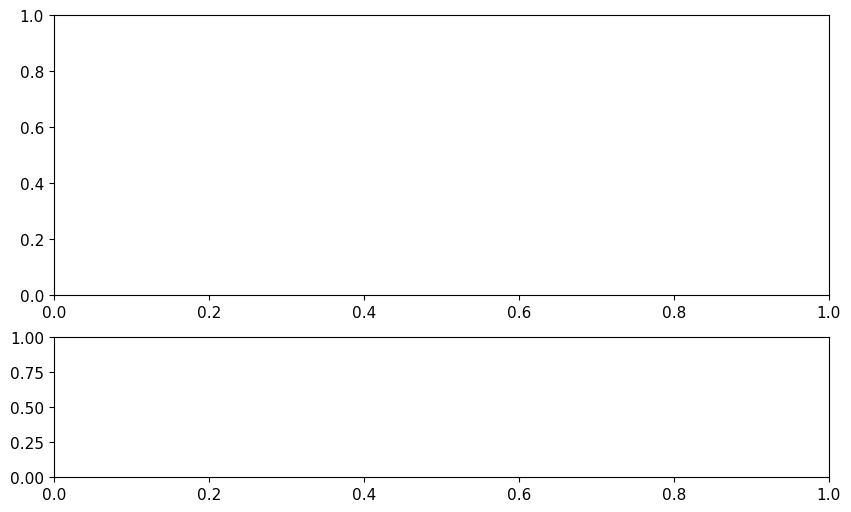

In [138]:
from scipy.stats import truncexpon, uniform
from iminuit import Minuit
import matplotlib.pyplot as plt
import numpy as np

xr = (0, 5000)

def integral_all_free(x, *par):
    result = par[2] * ((par[0] * truncexpon.cdf(x, *xr, 0.0, par[1]) +
                       (1 - par[0]) * truncexpon.cdf(x, *xr, 0.0, par[4]))) + par[3] * uniform.cdf(x, *xr)
    return np.nan_to_num(result, nan=0.0)  # Replace NaN values with 0

# Generate some example data
data = np.random.exponential(scale=500, size=10000)  # Replace this with your actual data

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios': [2, 1]})

# Histogram the data
n, xe = np.histogram(data, bins=100)

cx = 0.5 * (xe[1:] + xe[:-1])
c = cost.ExtendedBinnedNLL(n, xe, integral_all_free)

left_lim = 0
right_lim = 5000
c.mask = (cx > left_lim) & (cx < right_lim)

# Initial parameter values for the fit
initial_params = (1/3, 200, 10000, 5000, 1160)

# Perform the fit
m = Minuit(c, *initial_params)
m.limits[0] = (0, 1)
m.limits[1] = (0, 100)
#print(m.migrad())

# Compute chi-square
chi2 = m.fval / (len(xe) - m.nfit)
chi2 = np.around(chi2, 2)
print(f'chi2: {chi2:.2f}')

# Plot the histogram
ax.hist(data, bins=xe, color="#CCCCCC", label=f"Data")

# Plot the fitted model
ax.stairs(np.diff(integral_all_free(xe, m.values)), xe, baseline=None, linewidth=1.2,
          label=f"\nFitted Model\n" + r'$\chi^2/n_{dof} = $' + f'{chi2:.2f}', color="#1A2A5B")

# Add an inset
left, bottom, width, height = [0.3, 0.7, 0.15, 0.15]
inset_ax = fig.add_axes([left, bottom, width, height])
inset_ax.hist(data, bins=xe, color="#CCCCCC")
inset_ax.stairs(np.diff(integral_all_free(xe, m.values)), xe, baseline=None, linewidth=1.2,
                label=rf"Fit", color="#1A2A5B")
inset_ax.set_xlim(0, 96)  # Set the x-axis limit for the inset
bin_size = 16
inset_ax.set_xticks([i * bin_size for i in range(0, 7)])
inset_ax.set_yticks([0, 1000, 2000])
inset_ax.set_xlabel(r'$t_i^{spms} - t_0^{spms}$ (ns)')

# Plot residuals
residuals = (np.diff(integral_all_free(xe, m.values)) - n) / np.sqrt(n)
ax2.scatter(cx, residuals, s=6, color='#1A2A5B')
ax2.set_axisbelow(True)
ax2.set_yticks([-10, -5, 0, 5, 10, 15])
ax2.minorticks_off()
ax2.yaxis.grid(True, linestyle=':')

# Set labels and titles
ax.set_ylabel('Counts', fontsize=14)
ax2.set_xlabel(r'Time difference $t_i^{spms} - t_0^{spms}$ (ns)', fontsize=14)
ax2.set_ylabel(r'Residuals ($\sigma$)', fontsize=14)

ax.set_xticks([])
ax.set_yscale("log")
fig.subplots_adjust(wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)

# Add legend
handles, labels = ax.get_legend_handles_labels()
order = [0, 1]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc='upper right', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)

plt.show()


In [108]:
#n, xe = 2*np.arange(len(sum_wfs_norm_cal))[1:], sum_wfs_norm_cal


In [109]:
np.histogram(sum_wfs_norm_cal, bins=7500)

(array([1, 0, 0, ..., 0, 0, 1]),
 array([0.00030267, 0.00031305, 0.00032343, ..., 0.07815229, 0.07816267,
        0.07817306], dtype=float32))

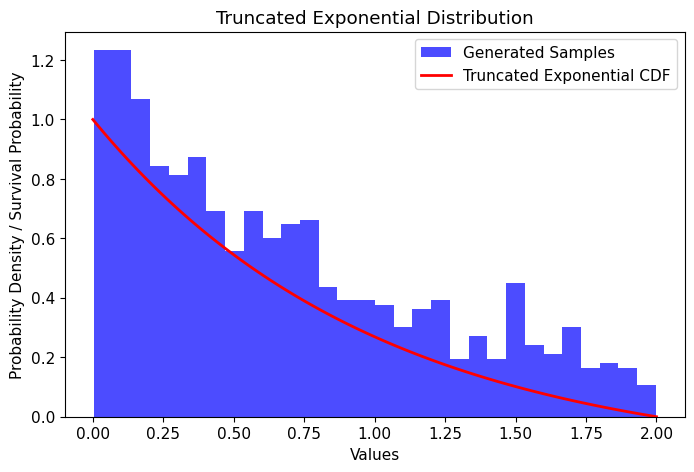

In [72]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import truncexpon

# Set the random seed for reproducibility
np.random.seed(42)

# Define parameters for the distribution
b = 2.0  # Upper bound of the distribution

# Generate random samples from the truncated exponential distribution
samples = truncexpon.rvs(b, size=1000)

# Plot the histogram of the generated samples
plt.hist(samples, bins=30, density=True, alpha=0.7, color='blue', label='Generated Samples')

# Plot the cumulative distribution function (CDF) of the truncated exponential distribution
x = np.linspace(0, b, 100)
cdf_trunc = truncexpon.sf(x, b)  # sf is the survival function (1 - CDF)
plt.plot(x, cdf_trunc, 'r-', lw=2, label='Truncated Exponential CDF')

plt.title('Truncated Exponential Distribution')
plt.xlabel('Values')
plt.ylabel('Probability Density / Survival Probability')
plt.legend()
plt.show()


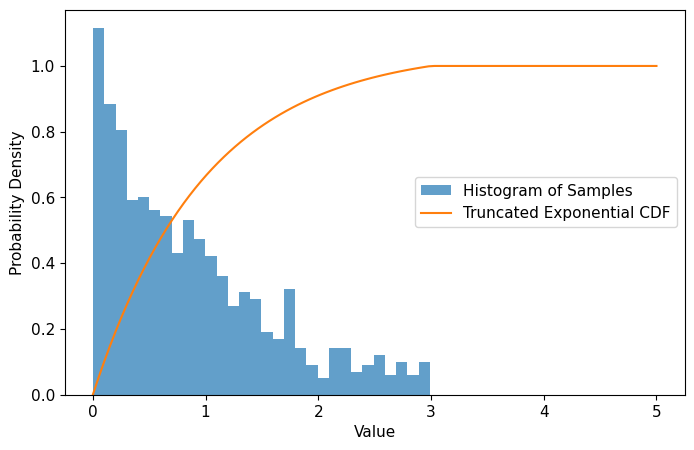

In [73]:
import numpy as np
from scipy.stats import truncexpon
import matplotlib.pyplot as plt

# Parameters
b   = 3.0  # Upper bound for truncation
loc = 0  # Location parameter (shift)
scale = 1  # Scale parameter (rate for exponential distribution)

# Generate random samples from a truncated exponential distribution
samples = truncexpon.rvs(b, loc=loc, scale=scale, size=1000)

# Create an array of values for which to calculate the CDF
x_values = np.linspace(0, 5, 100)

# Calculate the CDF values for each x
cdf_values = truncexpon.cdf(x_values, b, loc=loc, scale=scale)

# Plot the histogram of generated samples
plt.hist(samples, bins=30, density=True, alpha=0.7, label='Histogram of Samples')

# Plot the theoretical CDF
plt.plot(x_values, cdf_values, label='Truncated Exponential CDF')

# Set labels and legend
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()


In [86]:
import numpy as np
from scipy.stats import truncexpon
from iminuit import Minuit
import matplotlib.pyplot as plt

# Generate some data from a truncated exponential distribution
b = 3.0  # Upper bound for truncation
loc = 0  # Location parameter (shift)
scale = 1  # Scale parameter (rate for exponential distribution)
data = truncexpon.rvs(b, loc=loc, scale=scale, size=1000)

# Define the truncated exponential CDF function
def cdf(x, b, loc, scale):
    return truncexpon.cdf(x, b, loc=loc, scale=scale)

# Define the negative log-likelihood function
def negative_log_likelihood(params):
    return -np.sum(np.log(cdf(data, *params)))

# Initial parameter values
initial_params = (2.0, 1.0, 0.5)  # Choose reasonable initial values

# Create a Minuit object
m = Minuit(negative_log_likelihood, params=initial_params, error_params=0.1, print_level=0)

# Run the minimization
m.migrad()

# Get the best-fit parameters
best_fit_params = m.values
errors = m.errors

# Plot the histogram of the data
plt.hist(data, bins=30, density=True, alpha=0.7, label='Data Histogram')

# Plot the fitted truncated exponential CDF
x_values = np.linspace(0, 5, 100)
cdf_values = cdf(x_values, *best_fit_params)
plt.plot(x_values, cdf_values, label='Fitted Truncated Exponential CDF')

# Set labels and legend
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()

# Display the best-fit parameters and their errors
print(f"Best-fit parameters: {best_fit_params}")
print(f"Parameter errors: {errors}")


RuntimeError: error_params is not one of the parameters [params]

In [87]:
Minuit?

## Try with interpolate

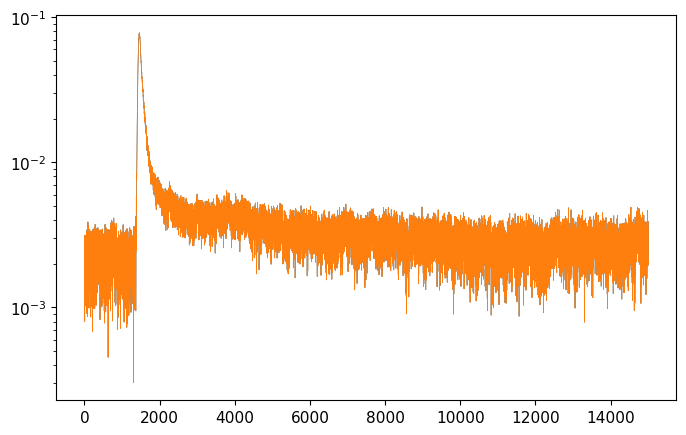

In [94]:
from scipy import interpolate

f0   = interpolate.interp1d(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal, fill_value="extrapolate")
ynew = f0(2*np.arange(len(sum_wfs_norm_cal)))   # use interpolation function returned by `interp1d`
plt.plot(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal, 2*np.arange(len(sum_wfs_norm_cal)), ynew, "-", linewidth=0.5)
plt.yscale('log')
plt.show()

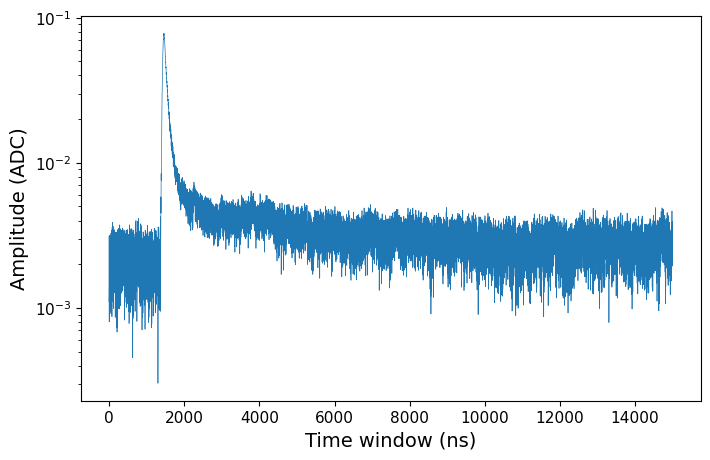

In [88]:
sel_ch = 0
sum_wfs_norm_cal = summed_swfs_norm_join_evts_dict[sel_ch]/gain
plt.plot(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal, linewidth=0.5, label=f'ch = {ch}')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
plt.yscale('log')
plt.show()

### Test with a gaussian function

In [136]:
from numba_stats import truncnorm, truncexpon, norm, expon

xr = (0, 2)  # xrange

rng = np.random.default_rng(1)

xdata = rng.normal(1, 0.1, size=1000)
ydata = rng.exponential(size=len(xdata))
xmix = np.append(xdata, ydata)
xmix = xmix[(xr[0] < xmix) & (xmix < xr[1])]

n, xe = np.histogram(xmix, bins=20, range=xr)
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)

def integral(xe, s, b, mu, sigma, tau):
    return (s * truncnorm.cdf(xe, *xr, mu, sigma) +
            b * truncexpon.cdf(xe, *xr, 0, tau))

c = cost.ExtendedBinnedNLL(n, xe, integral)
m = Minuit(c, s=300, b=1500, mu=0, sigma=0.2, tau=2)
m.limits["s", "b", "sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 15.03 (χ²/ndof = 1.0)      │              Nfcn = 437              │
│ EDM = 1e-06 (Goal: 0.0002)       │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  1.02e3   │  0.04e3   │            │            │    0    │         │       │
│ 1 │ b     │    867    │    35     │            │            │    0    │         │       │
│ 2 │ mu    │   0.995   │   0.004   │            │            │         │         │       │
│ 3 │ sigma │   0.100   │   0.004   │            │            │    0    │         │       │
│ 4 │ tau   │   1.05    │   0.08    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬────────────────────────────────────────────────────────┐
│       │          s          b         mu      sigma        tau │
├───────┼────────────────────────────────────────────────────────┤
│     s │   1.38e+03     -0.4e3  -7.764e-3  38.616e-3     -0.452 │
│     b │     -0.4e3   1.23e+03   7.764e-3 -38.615e-3      0.452 │
│    mu │  -7.764e-3   7.764e-3   1.63e-05  -0.001e-3  -0.015e-3 │
│ sigma │  38.616e-3 -38.615e-3  -0.001e-3   1.43e-05  -0.045e-3 │
│   tau │     -0.452      0.452  -0.015e-3  -0.045e-3    0.00564 │
└───────┴────────────────────────────────────────────────────────┘

In [135]:
!pip install numba_stats

In [158]:
xr = (0, 0.02)  # xrange

rng = np.random.default_rng(1)

n, xe = np.histogram(sum_wfs_norm_cal, bins=100, range=xr)
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)

def integral(xe, s, b, mu, sigma, tau):
    return (s * truncnorm.cdf(xe, *xr, mu, sigma) +
            b * truncexpon.cdf(xe, *xr, 0, tau))

c = cost.ExtendedBinnedNLL(n, xe, integral)
m = Minuit(c, s=300, b=1500, mu=0, sigma=0.2, tau=2)
m.limits["s", "b", "sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 8583 (χ²/ndof = 90.4)      │              Nfcn = 555              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │ 8.0117e-4 │    nan    │            │            │    0    │         │       │
│ 1 │ b     │ 7.4038e3  │    nan    │            │            │    0    │         │       │
│ 2 │ mu    │ -7.878e-1 │    nan    │            │            │         │         │       │
│ 3 │ sigma │ 1.9999e-1 │    nan    │            │            │    0    │         │       │
│ 4 │ tau   │ 3.1556e-3 │    nan    │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │     s     b    mu sigma   tau │
├───────┼───────────────────────────────┤
│     s │   nan   nan   nan   nan   nan │
│     b │   nan   nan   nan   nan   nan │
│    mu │   nan   nan   nan   nan   nan │
│ sigma │   nan   nan   nan   nan   nan │
│   tau │   nan   nan   nan   nan   nan │
└───────┴───────────────────────────────┘

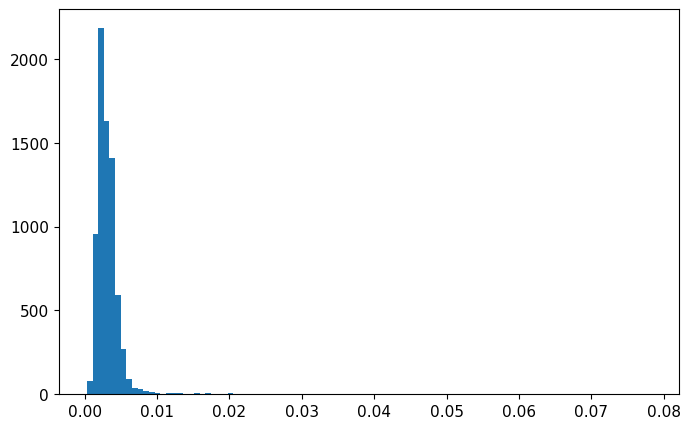

In [157]:
plt.hist(sum_wfs_norm_cal, bins=100);

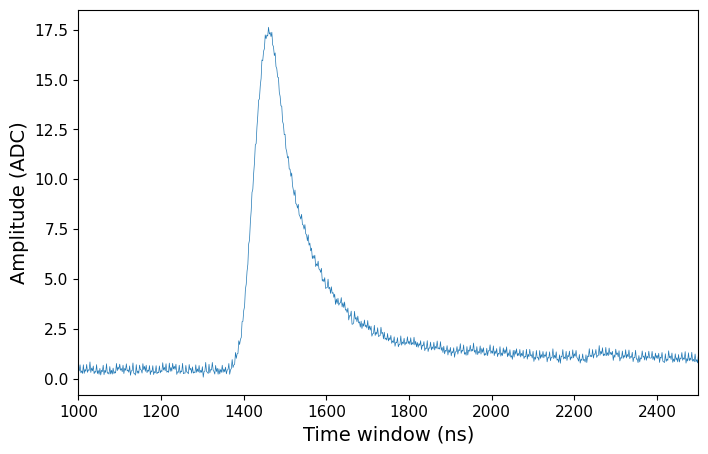

In [161]:
sel_ch = 0
sum_wfs_norm_cal = summed_swfs_norm_join_evts_dict[sel_ch]#/gain
plt.plot(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal, linewidth=0.5, label=f'ch = {ch}')
plt.xlabel('Time window (ns)', fontsize=14)
plt.ylabel('Amplitude (ADC)',  fontsize=14)
#plt.yscale('log')
plt.xlim(1000,2500)
plt.show()

In [186]:
data = np.hstack(np.array([i*np.ones(int(j*10)) for i,j in zip(2*np.arange(len(sum_wfs_norm_cal)), sum_wfs_norm_cal)]))

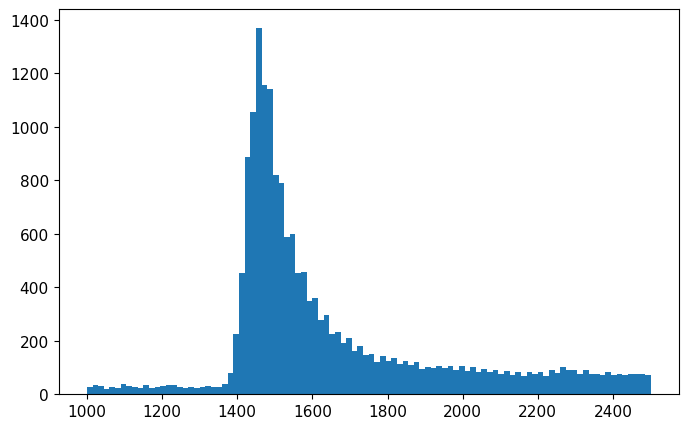

In [190]:
plt.hist(data, bins=100, range=(1000, 2500));

In [191]:
xr = (1000, 2500)  # xrange

n, xe = np.histogram(data, bins=100, range=xr)
cx = 0.5 * (xe[1:] + xe[:-1])
dx = np.diff(xe)

def integral(xe, s, b, mu, sigma, tau):
    return (s * truncnorm.cdf(xe, *xr, mu, sigma) +
            b * truncexpon.cdf(xe, *xr, 0, tau))

c = cost.ExtendedBinnedNLL(n, xe, integral)
m = Minuit(c, s=1000, b=1500, mu=1500, sigma=20, tau=1000)
m.limits["s", "b", "sigma", "tau"] = (0, None)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 3552 (χ²/ndof = 37.4)      │              Nfcn = 637              │
│ EDM = 2.07e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ s     │  10.00e3  │  0.12e3   │            │            │    0    │         │       │
│ 1 │ b     │  8.07e3   │  0.11e3   │            │            │    0    │         │       │
│ 2 │ mu    │ 1.4952e3  │ 0.0008e3  │            │            │         │         │       │
│ 3 │ sigma │   60.2    │    0.8    │            │            │    0    │         │       │
│ 4 │ tau   │   2.5e9   │   1.3e9   │            │            │    0    │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬─────────────────────────────────────────────────────────────┐
│       │           s           b          mu       sigma         tau │
├───────┼─────────────────────────────────────────────────────────────┤
│     s │    1.34e+04    -0.003e6        22.7        28.5     8.189e6 │
│     b │    -0.003e6    1.15e+04       -22.7       -28.5    39.159e6 │
│    mu │        22.7       -22.7       0.716         0.3  -40.4852e3 │
│ sigma │        28.5       -28.5         0.3       0.601 -146.1014e3 │
│   tau │     8.189e6    39.159e6  -40.4852e3 -146.1014e3     1.6e+18 │
└───────┴─────────────────────────────────────────────────────────────┘

In [209]:
from scipy.stats import uniform
from numba_stats import truncnorm, truncexpon, norm, expon
from iminuit import cost
from iminuit import Minuit

xr = (1000,2500)

#n, xe = 2*np.arange(len(sum_wfs_norm_cal))[1:], sum_wfs_norm_cal
n, xe = np.histogram(data, bins=100)


#cx = 0.5 * (xe[1:] + xe[:-1])
c  = cost.ExtendedBinnedNLL(n, xe, integral_all_free)

left_lim  = 1000
right_lim = 2500
#c.mask    = (cx > left_lim) & (cx < right_lim)

m = Minuit(c, b=1500, tau1=6, s1=10000, s2=2500, tau2=1160)

#m.limits[0] = (0, 1)
#m.limits[1] = (0,100)
print(m.migrad())
print(m.fval)
chi2 = m.fval / (len(xe) - m.nfit)
chi2 = np.around(chi2, 2)
#print(f'chi2: {chi2:.2f}')

ax.hist(data, bins = xe, color = "#CCCCCC",
        label = f"K42 data\n(LAr intensity <= p.e.)"
        )

lw = 1.2
fs = 14

signal_to_bkg = np.around(m.values[2]/m.values[3], 2)
sig_to_trip = m.values[0]/(1-m.values[0])
ax.stairs(np.diff(integral_all_free(xe, *m.values)), xe, baseline=None,  linewidth = lw,
            label=f"\nscintillation pdf + const. bkg\n"+r'$\chi^2/n_{dof} = $'+f'{chi2:.2f}'+f'\nsinglet-to-triplet {sig_to_trip:.2f}\n'+r'$\tau_s = $'+f'{m.values[1]:.1f} ns' +r'$, \tau_t = $'+f'{m.values[3]:.1f} ns', color = "#1A2A5B") # \n S/B = {signal_to_bkg:.2f}

y, ycov = propagate(lambda p: np.diff(integral_all_free(xe, p)), m.values, m.covariance)
yerr_prop = np.diag(ycov) ** 0.5
ax.fill_between(cx, y - yerr_prop, y + yerr_prop, facecolor="#1A2A5B", alpha=0.5)

# Add an inset
left, bottom, width, height = [0.3, 0.7, 0.15, 0.15]
inset_ax = fig.add_axes([left, bottom, width, height])
inset_ax.hist(data, bins = xe, color = "#CCCCCC")
inset_ax.stairs(np.diff(integral_all_free(xe, *m.values)), xe, baseline=None,  linewidth = lw,
            label=rf"fit", color = "#1A2A5B")
inset_ax.set_xlim(0, 96)  # Set the x-axis limit for the inset
bin_size = 16
inset_ax.set_xticks([i * bin_size for i in range(0, 7)])
inset_ax.set_yticks([0,1000,2000])
inset_ax.set_xlabel(r'$t_i^{spms} - t_0^{spms}$ (ns)')

residuals = (np.diff(integral_all_free(xe, m.values)) - n) / np.sqrt(n)
ax2.scatter(cx, residuals, s=6, color = '#1A2A5B')
ax2.set_axisbelow(True)
ax2.set_yticks([-10,-5,0,5,10,15])
ax2.minorticks_off()
ax2.yaxis.grid(True, linestyle=':')

ax.set_ylabel('counts (1/16ns)', fontsize=fs)
ax2.set_xlabel(r'time difference $t_i^{spms} - t_0^{spms}$ (ns)', fontsize=fs)
ax2.set_ylabel(r'residuals ($\sigma$)', fontsize=fs)

ax.set_xticks([])
ax.set_yscale("log")
fig.subplots_adjust(wspace=0, hspace=0)
plt.subplots_adjust(wspace=0, hspace=0)

handles, labels = ax.get_legend_handles_labels()
order = [0,1]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc = 'upper right', fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)
ax2.tick_params(axis='both', which='major', labelsize=fs)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = nan                        │              Nfcn = 441              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

NameError: name 'propagate' is not defined

In [204]:
m

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = nan                        │              Nfcn = 441              │
│ EDM = nan (Goal: 0.0002)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│         INVALID Minimum          │   ABOVE EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ b    │    1e2    │    nan    │            │            │         │         │       │
│ 1 │ tau1 │     6     │    nan    │            │            │         │         │       │
│ 2 │ s1   │    1e4    │    nan    │            │            │         │         │       │
│ 3 │ s2   │   2.5e3   │    nan    │            │            │         │         │       │
│ 4 │ tau2 │  1.16e3   │    nan    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬──────────────────────────┐
│      │    b tau1   s1   s2 tau2 │
├──────┼──────────────────────────┤
│    b │  nan  nan  nan  nan  nan │
│ tau1 │  nan  nan  nan  nan  nan │
│   s1 │  nan  nan  nan  nan  nan │
│   s2 │  nan  nan  nan  nan  nan │
│ tau2 │  nan  nan  nan  nan  nan │
└──────┴──────────────────────────┘

Fitted Parameters: <ValueView amplitude=1.9723098151005982 decay_constant=0.5561372437977853 offset=0.05811813688657839>


TypeError: __main__.exponential_decay() argument after ** must be a mapping, not ValueView

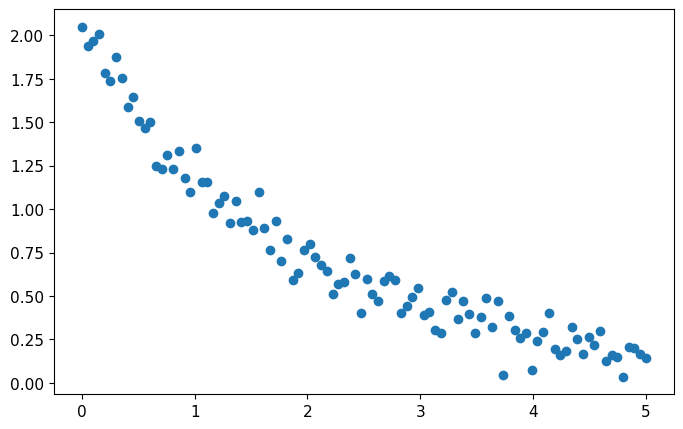

In [206]:
from iminuit import Minuit
import numpy as np
import matplotlib.pyplot as plt

# Generate example data
np.random.seed(42)
xdata = np.linspace(0, 5, 100)
ydata = 2 * np.exp(-0.5 * xdata) + 0.1 * np.random.normal(size=len(xdata))

# Define the exponential decay model
def exponential_decay(x, amplitude, decay_constant, offset):
    return amplitude * np.exp(-decay_constant * x) + offset

# Define the cost function (negative log-likelihood)
def cost_function(amplitude, decay_constant, offset):
    model = exponential_decay(xdata, amplitude, decay_constant, offset)
    return np.sum((ydata - model)**2)

# Initial parameter values
initial_params = {'amplitude': 1.0, 'decay_constant': 0.1, 'offset': 0.0}

# Create Minuit object and set initial parameter values
m = Minuit(cost_function, **initial_params)

# Fit the model using Minuit
m.migrad()

# Get the fitted parameters
fitted_params = m.values
print("Fitted Parameters:", fitted_params)

# Plot the original data and the fitted exponential decay
plt.scatter(xdata, ydata, label='Data')
plt.plot(xdata, exponential_decay(xdata, **fitted_params), label='Fit', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()
